In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

Ouverture des fichiers

In [5]:
parcoursup = "parcoursup.csv"

df = pd.read_csv(parcoursup, sep=";")
df.head()

,Session,"Statut de l’établissement de la filière de formation (public, privé…)",Code UAI de l'établissement,Établissement,Code départemental de l’établissement,Département de l’établissement,Région de l’établissement,Académie de l’établissement,Commune de l’établissement,Filière de formation,...,tri,cod_aff_form,Concours communs et banque d'épreuves,Lien de la formation sur la plateforme Parcoursup,Taux d’accès,Part des terminales générales qui étaient en position de recevoir une proposition en phase principale,Part des terminales technologiques qui étaient en position de recevoir une proposition en phase principale,Part des terminales professionnelles qui étaient en position de recevoir une proposition en phase principale,etablissement_id_paysage,composante_id_paysage
0,2024,Privé sous contrat d'association,0840940R,Lycée St Jean Baptiste De La Salle,84.0,Vaucluse,Provence-Alpes-Côte d'Azur,Aix-Marseille,Avignon,"BTS - Production - Cybersécurité, Informatique...",...,2_Lycées,10463,NaN,https://dossier.parcoursup.fr/Candidats/public...,53.0,33.0,28.0,38.0,NaN,NaN
1,2024,Privé sous contrat d'association,0850076W,Lycée général et technologique privé Jean XXIII,85.0,Vendée,Pays-de-la-Loire,Nantes,Les Herbiers,BTS - Services - Management Commercial Opérati...,...,2_Lycées,10489,NaN,https://dossier.parcoursup.fr/Candidats/public...,99.0,19.0,52.0,28.0,NaN,NaN
2,2024,Public,0860005N,Cite Technique Edouard Branly,86.0,Vienne,Nouvelle Aquitaine,Poitiers,Châtellerault,BTS - Services - Professions immobilières,...,2_Lycées,10577,NaN,https://dossier.parcoursup.fr/Candidats/public...,62.0,34.0,51.0,15.0,NaN,NaN
3,2024,Public,0860038Z,Lycée Aliénor d' Aquitaine,86.0,Vienne,Nouvelle Aquitaine,Poitiers,Poitiers,BTS - Services - Services informatiques aux or...,...,2_Lycées,10596,NaN,https://dossier.parcoursup.fr/Candidats/public...,72.0,31.0,37.0,32.0,NaN,NaN
4,2024,Public,0861283C,I.U.T. Poitiers (site Chatellerault),86.0,Vienne,Nouvelle Aquitaine,Poitiers,Châtellerault,BUT - Mesures physiques,...,1_universités,10654,NaN,https://dossier.parcoursup.fr/Candidats/public...,93.0,88.0,12.0,0.0,hlX1r,NaN


Ouverture des fichiers zip

In [6]:
import requests
import zipfile
import io
import os

url = "https://www.data.gouv.fr/api/1/datasets/r/476f4243-c0de-4f7c-84bf-ec88ba8cd62b"

# Télécharger le contenu du ZIP
response = requests.get(url)
if response.status_code == 200:
    # Ouvrir l’archive ZIP en mémoire sans l’enregistrer sur disque
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # Lister les fichiers contenus
        print("Fichiers dans le ZIP :", z.namelist())
        
        # Dossier où extraire les fichiers
        output_dir = "dossier_extraction"
        os.makedirs(output_dir, exist_ok=True)
        
        # Extraire tous les fichiers sauf ceux en .dbf
        for file_name in z.namelist():
            if not file_name.lower().endswith(".dbf"):
                z.extract(file_name, output_dir)
        
        print("Extraction terminée sans les fichiers .dbf.")
else:
    print("Erreur lors du téléchargement, status:", response.status_code)

Fichiers dans le ZIP : ['referents-contours-iris.prj', 'referents-contours-iris.cpg', 'referents-contours-iris.dbf', 'referents-contours-iris.shp', 'referents-contours-iris.shx']
Extraction terminée sans les fichiers .dbf.


In [7]:
dfg = gpd.read_file("dossier_extraction/referents-contours-iris.shp")
dfg.head()

,code_iris,nom_iris,type_iris,code_commun,nom_commune,code_epci,code_depart,code_region,geo_shape,geometry
0,060882103,La Bornala,H,06088,Nice,200030195,06,93,"{""coordinates"": [[[7.241808, 43.693709], [7.24...",POINT (7.23443 43.69666)
1,764630000,Neuf-Marché,Z,76463,Neuf-Marché,200069730,76,28,"{""coordinates"": [[[1.695886, 49.446644], [1.69...",POINT (1.69206 49.42222)
2,911610107,Rue de Gravigny,H,91161,Chilly-Mazarin,200056232,91,11,"{""coordinates"": [[[2.306928, 48.695966], [2.30...",POINT (2.31039 48.69287)
3,393440000,Monnet-la-Ville,Z,39344,Monnet-la-Ville,200069623,39,27,"{""coordinates"": [[[5.855132, 46.735644], [5.86...",POINT (5.81452 46.72444)
4,852260101,Centre Ville,H,85226,Saint-Hilaire-de-Riez,200023778,85,52,"{""coordinates"": [[[-1.922218, 46.724624], [-1....",POINT (-1.94362 46.71573)


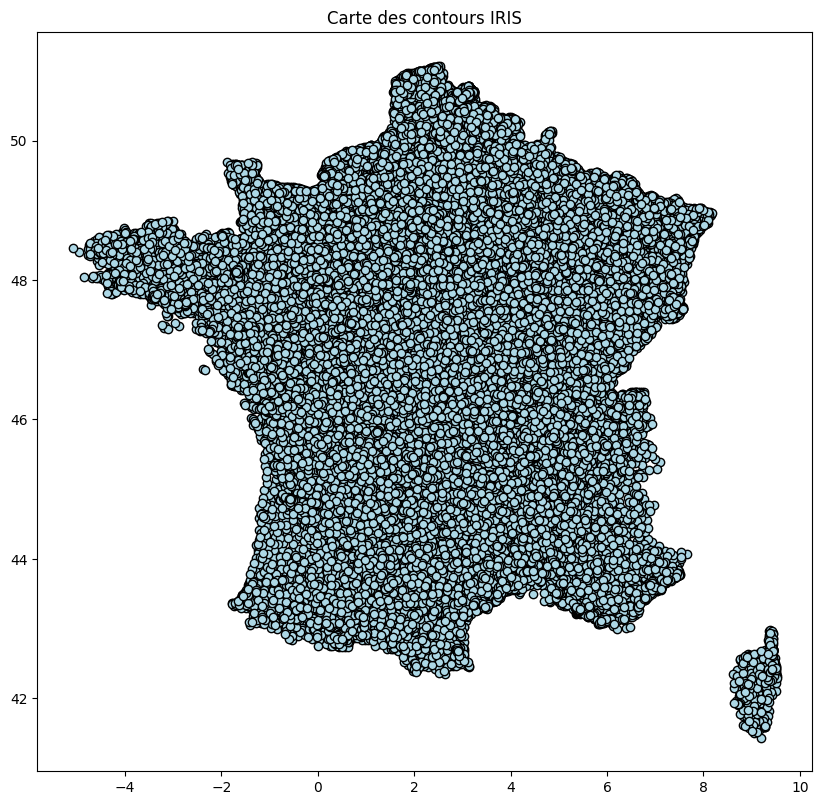

In [8]:
dfg.plot(figsize=(10, 10), edgecolor='black', color='lightblue')
plt.title("Carte des contours IRIS")
plt.show()

In [9]:
print(dfg.columns)

Index(['code_iris', 'nom_iris', 'type_iris', 'code_commun', 'nom_commune',
       'code_epci', 'code_depart', 'code_region', 'geo_shape', 'geometry'],
      dtype='object')


In [10]:
import requests
import zipfile
import io
import pandas as pd
import os

# URL du ZIP
url = "https://www.data.gouv.fr/api/1/datasets/r/476f4243-c0de-4f7c-84bf-ec88ba8cd62b"

# Dossier où extraire
dossier_extraction = "dossier_extraction"

# Télécharger le ZIP
response = requests.get(url)
if response.status_code != 200:
    raise Exception(f"Erreur téléchargement : {response.status_code}")

# Ouvrir le ZIP en mémoire
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Extraire tout sauf les DBF sauf celui qui nous intéresse
    for f in z.namelist():
        # On garde tous les fichiers sauf les DBF inutiles
        if f.endswith("referents-contours-iris.dbf") or not f.endswith(".dbf"):
            z.extract(f, dossier_extraction)

gdf = gpd.read_file("dossier_extraction/referents-contours-iris.shp")

# Afficher les colonnes disponibles
print(gdf.columns)

# Afficher quelques noms
print(gdf.head())


Index(['code_iris', 'nom_iris', 'type_iris', 'code_commun', 'nom_commune',
       'code_epci', 'code_depart', 'code_region', 'geo_shape', 'geometry'],
      dtype='object')
   code_iris         nom_iris type_iris code_commun            nom_commune  \
0  060882103       La Bornala         H       06088                   Nice   
1  764630000      Neuf-Marché         Z       76463            Neuf-Marché   
2  911610107  Rue de Gravigny         H       91161         Chilly-Mazarin   
3  393440000  Monnet-la-Ville         Z       39344        Monnet-la-Ville   
4  852260101     Centre Ville         H       85226  Saint-Hilaire-de-Riez   

   code_epci code_depart code_region  \
0  200030195          06          93   
1  200069730          76          28   
2  200056232          91          11   
3  200069623          39          27   
4  200023778          85          52   

                                           geo_shape  \
0  {"coordinates": [[[7.241808, 43.693709], [7.24...   
1  {"

In [11]:
gdf.head()

,code_iris,nom_iris,type_iris,code_commun,nom_commune,code_epci,code_depart,code_region,geo_shape,geometry
0,060882103,La Bornala,H,06088,Nice,200030195,06,93,"{""coordinates"": [[[7.241808, 43.693709], [7.24...",POINT (7.23443 43.69666)
1,764630000,Neuf-Marché,Z,76463,Neuf-Marché,200069730,76,28,"{""coordinates"": [[[1.695886, 49.446644], [1.69...",POINT (1.69206 49.42222)
2,911610107,Rue de Gravigny,H,91161,Chilly-Mazarin,200056232,91,11,"{""coordinates"": [[[2.306928, 48.695966], [2.30...",POINT (2.31039 48.69287)
3,393440000,Monnet-la-Ville,Z,39344,Monnet-la-Ville,200069623,39,27,"{""coordinates"": [[[5.855132, 46.735644], [5.86...",POINT (5.81452 46.72444)
4,852260101,Centre Ville,H,85226,Saint-Hilaire-de-Riez,200023778,85,52,"{""coordinates"": [[[-1.922218, 46.724624], [-1....",POINT (-1.94362 46.71573)


Relier les IRIS à parcoursup

In [12]:
print(df.columns)

Index(['Session',
       'Statut de l’établissement de la filière de formation (public, privé…)',
       'Code UAI de l'établissement', 'Établissement',
       'Code départemental de l’établissement',
       'Département de l’établissement', 'Région de l’établissement',
       'Académie de l’établissement', 'Commune de l’établissement',
       'Filière de formation',
       ...
       'tri', 'cod_aff_form', 'Concours communs et banque d'épreuves',
       'Lien de la formation sur la plateforme Parcoursup', 'Taux d’accès',
       'Part des terminales générales qui étaient en position de recevoir une proposition en phase principale',
       'Part des terminales technologiques qui étaient en position de recevoir une proposition en phase principale',
       'Part des terminales professionnelles qui étaient en position de recevoir une proposition en phase principale',
       'etablissement_id_paysage', 'composante_id_paysage'],
      dtype='object', length=118)


In [13]:
# Normaliser toutes les colonnes
df.columns = [
    col.lower()  # tout en minuscules
       .replace(' ', '_')       # espaces → _
       .replace("'", "_")       # apostrophes → _
       .replace('(', '')        # supprimer (
       .replace(')', '')        # supprimer )
       .replace('.', '')        # supprimer .
       .replace('…', '')
       .replace('é','e')        # accents
       .replace('è','e')
       .replace('à','a')
       .replace('ê','e')
       .replace('ç','c')
       .replace('%','percent')
       for col in df.columns
]

# Vérifier le résultat
print(df.columns)

Index(['session',
       'statut_de_l’etablissement_de_la_filiere_de_formation_public,_prive',
       'code_uai_de_l_etablissement', 'etablissement',
       'code_departemental_de_l’etablissement',
       'departement_de_l’etablissement', 'region_de_l’etablissement',
       'academie_de_l’etablissement', 'commune_de_l’etablissement',
       'filiere_de_formation',
       ...
       'tri', 'cod_aff_form', 'concours_communs_et_banque_d_epreuves',
       'lien_de_la_formation_sur_la_plateforme_parcoursup', 'taux_d’acces',
       'part_des_terminales_generales_qui_etaient_en_position_de_recevoir_une_proposition_en_phase_principale',
       'part_des_terminales_technologiques_qui_etaient_en_position_de_recevoir_une_proposition_en_phase_principale',
       'part_des_terminales_professionnelles_qui_etaient_en_position_de_recevoir_une_proposition_en_phase_principale',
       'etablissement_id_paysage', 'composante_id_paysage'],
      dtype='object', length=118)


In [14]:
df = df.rename(columns={"coordonnees_gps_de_la_formation": "coord_gps"})

df[['latitude', 'longitude']] = df['coord_gps'].str.split(',', expand=True)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)

# Vérifier
df[['latitude','longitude']].head()

,latitude,longitude
0,43.9486,4.81628
1,46.8655,-1.02739
2,46.8021,0.54320
3,46.5886,0.36542
4,46.8350,0.53499


In [15]:
lycees = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs="EPSG:4326"
)

In [16]:
print(lycees.geometry.head())

0     POINT (4.81628 43.9486)
1    POINT (-1.02739 46.8655)
2      POINT (0.5432 46.8021)
3     POINT (0.36542 46.5886)
4      POINT (0.53499 46.835)
Name: geometry, dtype: geometry


In [17]:
iris = gpd.read_file("dossier_extraction/referents-contours-iris.shp")
print(iris.crs)
print(lycees.crs)

EPSG:4326
EPSG:4326


In [18]:
lycees_iris = gpd.sjoin(lycees, iris, how="left", predicate="within")
lycees_iris.head()

,session,"statut_de_l’etablissement_de_la_filiere_de_formation_public,_prive",code_uai_de_l_etablissement,etablissement,code_departemental_de_l’etablissement,departement_de_l’etablissement,region_de_l’etablissement,academie_de_l’etablissement,commune_de_l’etablissement,filiere_de_formation,...,index_right,code_iris,nom_iris,type_iris,code_commun,nom_commune,code_epci,code_depart,code_region,geo_shape
0,2024,Privé sous contrat d'association,0840940R,Lycée St Jean Baptiste De La Salle,84.0,Vaucluse,Provence-Alpes-Côte d'Azur,Aix-Marseille,Avignon,"BTS - Production - Cybersécurité, Informatique...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024,Privé sous contrat d'association,0850076W,Lycée général et technologique privé Jean XXIII,85.0,Vendée,Pays-de-la-Loire,Nantes,Les Herbiers,BTS - Services - Management Commercial Opérati...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024,Public,0860005N,Cite Technique Edouard Branly,86.0,Vienne,Nouvelle Aquitaine,Poitiers,Châtellerault,BTS - Services - Professions immobilières,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024,Public,0860038Z,Lycée Aliénor d' Aquitaine,86.0,Vienne,Nouvelle Aquitaine,Poitiers,Poitiers,BTS - Services - Services informatiques aux or...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024,Public,0861283C,I.U.T. Poitiers (site Chatellerault),86.0,Vienne,Nouvelle Aquitaine,Poitiers,Châtellerault,BUT - Mesures physiques,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
print(lycees.geometry.x.min(), lycees.geometry.x.max())
print(lycees.geometry.y.min(), lycees.geometry.y.max())

-151.455 108.80562
-21.38179 53.3532


In [20]:
print(iris.total_bounds)
print(lycees.total_bounds)

[-5.085804 41.436138  9.529037 51.072888]
[-151.455    -21.38179  108.80562   53.3532 ]


In [21]:
minx, miny, maxx, maxy = iris.total_bounds
lycees_fr = lycees.cx[minx:maxx, miny:maxy]

In [22]:
print(iris.geom_type.value_counts())
print(iris.is_valid.value_counts())

Point    48580
Name: count, dtype: int64
True    48580
Name: count, dtype: int64


In [23]:
lycees_iris = gpd.sjoin(lycees_fr, iris, how="left", predicate="within")
lycees_iris.head()

,session,"statut_de_l’etablissement_de_la_filiere_de_formation_public,_prive",code_uai_de_l_etablissement,etablissement,code_departemental_de_l’etablissement,departement_de_l’etablissement,region_de_l’etablissement,academie_de_l’etablissement,commune_de_l’etablissement,filiere_de_formation,...,index_right,code_iris,nom_iris,type_iris,code_commun,nom_commune,code_epci,code_depart,code_region,geo_shape
0,2024,Privé sous contrat d'association,0840940R,Lycée St Jean Baptiste De La Salle,84.0,Vaucluse,Provence-Alpes-Côte d'Azur,Aix-Marseille,Avignon,"BTS - Production - Cybersécurité, Informatique...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024,Privé sous contrat d'association,0850076W,Lycée général et technologique privé Jean XXIII,85.0,Vendée,Pays-de-la-Loire,Nantes,Les Herbiers,BTS - Services - Management Commercial Opérati...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024,Public,0860005N,Cite Technique Edouard Branly,86.0,Vienne,Nouvelle Aquitaine,Poitiers,Châtellerault,BTS - Services - Professions immobilières,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024,Public,0860038Z,Lycée Aliénor d' Aquitaine,86.0,Vienne,Nouvelle Aquitaine,Poitiers,Poitiers,BTS - Services - Services informatiques aux or...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024,Public,0861283C,I.U.T. Poitiers (site Chatellerault),86.0,Vienne,Nouvelle Aquitaine,Poitiers,Châtellerault,BUT - Mesures physiques,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Assurer CRS identiques
lycees = lycees_fr.set_crs(iris.crs, allow_override=True)

# Vérifier chevauchement des limites
print("IRIS bounds:", iris.total_bounds)
print("Lycées bounds:", lycees.total_bounds)

IRIS bounds: [-5.085804 41.436138  9.529037 51.072888]
Lycées bounds: [-4.56664 41.6226   9.45279 51.05   ]


In [26]:
print(iris.is_valid.value_counts())

True    48580
Name: count, dtype: int64


In [27]:
lycees_iris = gpd.sjoin(lycees, iris, how="left", predicate="intersects")
lycees_iris.head()

,session,"statut_de_l’etablissement_de_la_filiere_de_formation_public,_prive",code_uai_de_l_etablissement,etablissement,code_departemental_de_l’etablissement,departement_de_l’etablissement,region_de_l’etablissement,academie_de_l’etablissement,commune_de_l’etablissement,filiere_de_formation,...,index_right,code_iris,nom_iris,type_iris,code_commun,nom_commune,code_epci,code_depart,code_region,geo_shape
0,2024,Privé sous contrat d'association,0840940R,Lycée St Jean Baptiste De La Salle,84.0,Vaucluse,Provence-Alpes-Côte d'Azur,Aix-Marseille,Avignon,"BTS - Production - Cybersécurité, Informatique...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024,Privé sous contrat d'association,0850076W,Lycée général et technologique privé Jean XXIII,85.0,Vendée,Pays-de-la-Loire,Nantes,Les Herbiers,BTS - Services - Management Commercial Opérati...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024,Public,0860005N,Cite Technique Edouard Branly,86.0,Vienne,Nouvelle Aquitaine,Poitiers,Châtellerault,BTS - Services - Professions immobilières,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024,Public,0860038Z,Lycée Aliénor d' Aquitaine,86.0,Vienne,Nouvelle Aquitaine,Poitiers,Poitiers,BTS - Services - Services informatiques aux or...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024,Public,0861283C,I.U.T. Poitiers (site Chatellerault),86.0,Vienne,Nouvelle Aquitaine,Poitiers,Châtellerault,BUT - Mesures physiques,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
def make_point(coord_str):
    lat, lon = map(float, coord_str.split(","))  # séparer et convertir en float
    return Point(lon, lat)  # attention : ordre longitude, latitude

lycees["geometry"] = lycees["coord_gps"].apply(make_point)

In [30]:
lycees = gpd.GeoDataFrame(lycees, geometry="geometry", crs="EPSG:4326")

In [31]:
lycees_iris = gpd.sjoin(lycees, iris, how="left", predicate="intersects")

In [32]:
lycees_iris.head()

,session,"statut_de_l’etablissement_de_la_filiere_de_formation_public,_prive",code_uai_de_l_etablissement,etablissement,code_departemental_de_l’etablissement,departement_de_l’etablissement,region_de_l’etablissement,academie_de_l’etablissement,commune_de_l’etablissement,filiere_de_formation,...,index_right,code_iris,nom_iris,type_iris,code_commun,nom_commune,code_epci,code_depart,code_region,geo_shape
0,2024,Privé sous contrat d'association,0840940R,Lycée St Jean Baptiste De La Salle,84.0,Vaucluse,Provence-Alpes-Côte d'Azur,Aix-Marseille,Avignon,"BTS - Production - Cybersécurité, Informatique...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024,Privé sous contrat d'association,0850076W,Lycée général et technologique privé Jean XXIII,85.0,Vendée,Pays-de-la-Loire,Nantes,Les Herbiers,BTS - Services - Management Commercial Opérati...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024,Public,0860005N,Cite Technique Edouard Branly,86.0,Vienne,Nouvelle Aquitaine,Poitiers,Châtellerault,BTS - Services - Professions immobilières,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024,Public,0860038Z,Lycée Aliénor d' Aquitaine,86.0,Vienne,Nouvelle Aquitaine,Poitiers,Poitiers,BTS - Services - Services informatiques aux or...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024,Public,0861283C,I.U.T. Poitiers (site Chatellerault),86.0,Vienne,Nouvelle Aquitaine,Poitiers,Châtellerault,BUT - Mesures physiques,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
lycees_iris.notna().sum()

session                                                               13322
statut_de_l’etablissement_de_la_filiere_de_formation_public,_prive    13322
code_uai_de_l_etablissement                                           13322
etablissement                                                         13322
code_departemental_de_l’etablissement                                 13251
                                                                      ...  
nom_commune                                                               0
code_epci                                                                 0
code_depart                                                               0
code_region                                                               0
geo_shape                                                                 0
Length: 131, dtype: int64

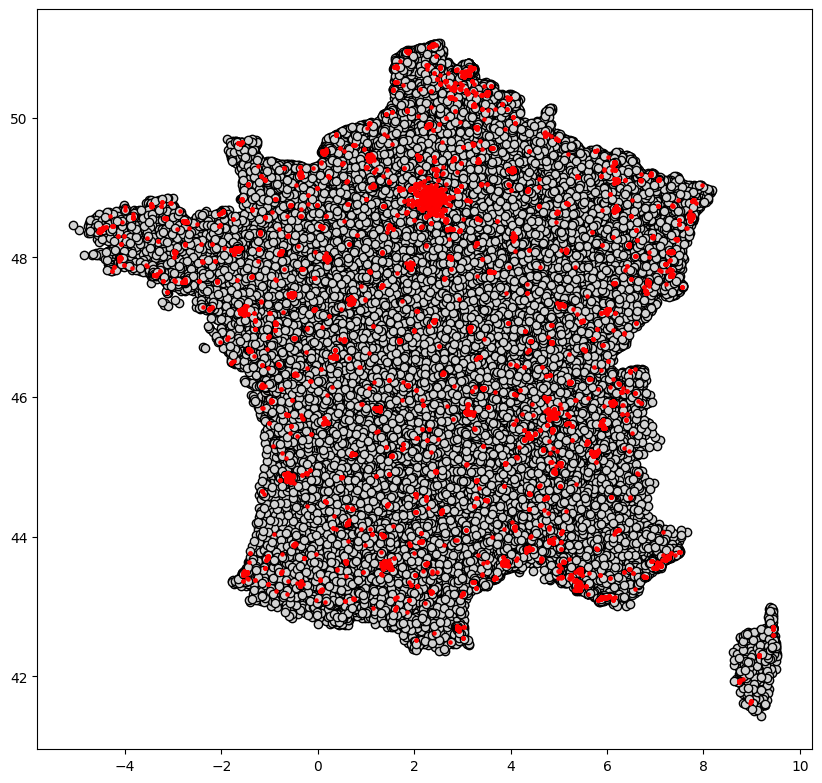

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
iris.plot(ax=ax, color="lightgrey", edgecolor="black")
lycees.plot(ax=ax, color="red", markersize=5)
plt.show()

In [ ]:
lycees['in_iris'] = lycees['geometry'].apply(lambda x: any(x.within(poly) for poly in iris['geometry']))

print(lycees['in_iris'].value_counts())